In [42]:
from xlcalibur import dataclasses, housekeeping, dataaccess 
from xlcalibur.xcom import Packets
from xlcalibur.systems import Systems
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import os
import matplotlib.patches as patches

In [43]:
def analyze_file(n):
    filepath = f"/data/xlcal/data/2024_convData-P-ns/Run{n:06d}.dat"
    print(f"read file Run{n:06d}.dat")

    infile = dataclasses.XDataFile(filepath)

    all_alignment = [p.Deserialize() for p in infile.Scan(Packets.X_PKT_ALIGNMENT_DATA)]
    
    good_alignment = [p for p in all_alignment if p.fit_valid]
    valid_alignment = [p for p in good_alignment if np.isfinite(p.center_x) and np.isfinite(p.center_y) and p.scale != 0]

    if not valid_alignment:
        print(f" Run{n:06d} empty, skip")
        return None

    meanx = np.average([a.center_x for a in valid_alignment])
    meany = np.average([a.center_y for a in valid_alignment])
    t0 = valid_alignment[0].time.to_mjd()
    tdata = [86400 * (a.time.to_mjd() - t0) for a in valid_alignment]
    xdata = [(a.center_x - meanx) / a.scale for a in valid_alignment]
    ydata = [(a.center_y - meany) / a.scale for a in valid_alignment]
    rotation_data = [a.angle * 180 / np.pi for a in valid_alignment]
    mjd_times = np.array(tdata) / 86400 + t0

    case1, case2, case3, case4, case5, case6, case7, case8, case9 = [], [], [], [], [], [], [], [], []

    for i in range(len(xdata)):
        x = xdata[i]
        y = ydata[i]
        t = rotation_data[i]
        mjd = mjd_times[i]

        if abs(x) < 2 and abs(y) < 2:
            case1.append(mjd)
        elif x > 2 and abs(y) < 2:
            case2.append(mjd)
        elif x < -2 and abs(y) < 2:
            case3.append(mjd)
        elif y > 2 and abs(x) < 2:
            case4.append(mjd)
        elif y < -2 and abs(x) < 2:
            case5.append(mjd)
        elif x > 2 and y > 2:
            case6.append(mjd)
        elif x > 2 and y < -2:
            case7.append(mjd)
        elif x < -2 and y < -2:
            case8.append(mjd)
        elif x < -2 and y > 2:
            case9.append(mjd)
        
    return case1, case2, case3, case4, case5, case6, case7, case8, case9, xdata, ydata

In [44]:
def save_all_runs(run_list):
    all_case1 = []
    all_case2 = []
    all_case3 = []
    all_case4 = []
    all_case5 = []
    all_case6 = []
    all_case7 = []
    all_case8 = []
    all_case9 = []

    for n in run_list:
        result = analyze_file(n)
        if result:
            c1, c2, c3, c4, c5, c6, c7, c8, c9, *_ = result
            all_case1.extend(c1)
            all_case2.extend(c2)
            all_case3.extend(c3)
            all_case4.extend(c4)
            all_case5.extend(c5)
            all_case6.extend(c6)
            all_case7.extend(c7)
            all_case8.extend(c8)
            all_case9.extend(c9)

    maxlen = max(len(all_case1), len(all_case2), len(all_case3), len(all_case4), len(all_case5), len(all_case6), len(all_case7), len(all_case8), len(all_case9))
    df = pd.DataFrame({
        "Case 1 (|X|,|Y|<2mm)": all_case1 + [None]*(maxlen - len(all_case1)),
        "Case 2 (X>2mm，|Y|<2mm)": all_case2 + [None]*(maxlen - len(all_case2)),
        "Case 3 (X<-2mm，|Y|<2mm)": all_case3 + [None]*(maxlen - len(all_case3)),
        "Case 4 (Y>2mm，|X|<2mm)": all_case4 + [None]*(maxlen - len(all_case4)),
        "Case 5 (Y<-2mm，|X|<2mm)": all_case5 + [None]*(maxlen - len(all_case5)),
        "Case 6 (X>2mm，Y>2mm)": all_case6 + [None]*(maxlen - len(all_case6)),
        "Case 7 (X>2mm，Y<-2mm)": all_case7 + [None]*(maxlen - len(all_case7)),
        "Case 8 (X<-2mm，Y<-2mm)": all_case8 + [None]*(maxlen - len(all_case8)),
        "Case 9 (X<-2mm，Y>2mm)": all_case9 + [None]*(maxlen - len(all_case9))
        
    })

    os.makedirs("output", exist_ok=True)
    df.to_csv("output/summary_all_mjd.csv", index=False)
    print("saved output/summary_all_mjd.csv")


In [45]:
# Visualization of spatial distribution

def draw_cases_from_xy(xdata, ydata):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np

    # Step 1: Classify each (x, y) into 1 of 9 spatial zones (case1 - case9)
    cases = {f"case{i+1}": [] for i in range(9)}
    for x, y in zip(xdata, ydata):
        if abs(x) < 2 and abs(y) < 2:
            cases["case1"].append((x, y))
        elif x > 2 and abs(y) < 2:
            cases["case2"].append((x, y))
        elif x < -2 and abs(y) < 2:
            cases["case3"].append((x, y))
        elif y > 2 and abs(x) < 2:
            cases["case4"].append((x, y))
        elif y < -2 and abs(x) < 2:
            cases["case5"].append((x, y))
        elif x > 2 and y > 2:
            cases["case6"].append((x, y))
        elif x > 2 and y < -2:
            cases["case7"].append((x, y))
        elif x < -2 and y < -2:
            cases["case8"].append((x, y))
        elif x < -2 and y > 2:
            cases["case9"].append((x, y))

    # Step 2: Create the plot canvas
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Step 3: Draw background color blocks for each of the 9 case zones
    # Each entry is: (x_start, y_start, width, height, color)
    regions = {
        "case1": (-2, -2, 4, 4, "lightyellow"),
        "case2": (2, -2, 4, 4, "pink"),
        "case3": (-6, -2, 4, 4, "lightgreen"),
        "case4": (-2, 2, 4, 4, "moccasin"),
        "case5": (-2, -6, 4, 4, "lightblue"),
        "case6": (2, 2, 4, 4, "thistle"),
        "case7": (2, -6, 4, 4, "lightgray"),
        "case8": (-6, -6, 4, 4, "burlywood"),
        "case9": (-6, 2, 4, 4, "mistyrose")
    }
    for k in cases:
        print(k, len(cases[k]))
    for name, (x, y, w, h, color) in regions.items():
        rect = patches.Rectangle((x, y), w, h, linewidth=0, facecolor=color, alpha=0.3)
        ax.add_patch(rect)

    # Step 4: Define unique colors for each case's points
    dot_colors = [
        'red', 'orange', 'green', 'blue', 'purple',
        'brown', 'gray', 'teal', 'darkred'
    ]

    # Step 5: Scatter the points for each case on top of background
    for i, (name, points) in enumerate(cases.items()):
        if points:
            coords = np.array(points)
            plt.scatter(coords[:, 0], coords[:, 1], label=name, color=dot_colors[i], s=20)

    # Step 6: Add dashed lines to delineate the zone boundaries
    plt.axvline(-2, linestyle='--', color='black', linewidth=0.8)
    plt.axvline(0, linestyle='-', color='black', linewidth=0.8)
    plt.axvline(2, linestyle='--', color='black', linewidth=0.8)
    plt.axhline(-2, linestyle='--', color='black', linewidth=0.8)
    plt.axhline(0, linestyle='-', color='black', linewidth=0.8)
    plt.axhline(2, linestyle='--', color='black', linewidth=0.8)

    # Step 7: Label the center of each zone with its case name
    label_pos = {
        "case1": (0, 0),
        "case2": (3.5, 0),
        "case3": (-3.5, 0),
        "case4": (0, 3.5),
        "case5": (0, -3.5),
        "case6": (3.5, 3.5),
        "case7": (3.5, -3.5),
        "case8": (-3.5, -3.5),
        "case9": (-3.5, 3.5)
    }
    for name, (x, y) in label_pos.items():
        plt.text(x, y, name, fontsize=12, weight='bold', ha='center', va='center')

    # Step 8: Final plot settings
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.xlabel("X-direction")
    plt.ylabel("Y-direction")
    plt.title("Spatial Distribution of back-looking camera")
    plt.legend()
    plt.grid(True)
    plt.savefig("case_distribution.png", dpi=300)
    plt.show()


read file Run014007.dat
/grad/ephraimgau/xlcalflightsoftware/source/core/src/core/XDataFile.cpp:65: DEBUG: Reading a file of format version 2
read file Run014008.dat
read file Run014009.dat
 Run014009 empty, skip
read file Run014010.dat
read file Run014011.dat
read file Run014012.dat
 Run014012 empty, skip
read file Run014013.dat
read file Run014014.dat
 Run014014 empty, skip
read file Run014015.dat
read file Run014016.dat
read file Run014017.dat
read file Run014018.dat
 Run014018 empty, skip
read file Run014019.dat
read file Run014020.dat
 Run014020 empty, skip
read file Run014021.dat
/grad/ephraimgau/xlcalflightsoftware/source/core/src/core/XDataFile.cpp:224: DEBUG: Types selected:  5
/grad/ephraimgau/xlcalflightsoftware/source/core/src/core/XDataFile.cpp:147: DEBUG: At end of file
/grad/ephraimgau/xlcalflightsoftware/source/core/src/core/XDataFile.cpp:65: DEBUG: Reading a file of format version 2
/grad/ephraimgau/xlcalflightsoftware/source/core/src/core/XDataFile.cpp:224: DEBUG: Typ

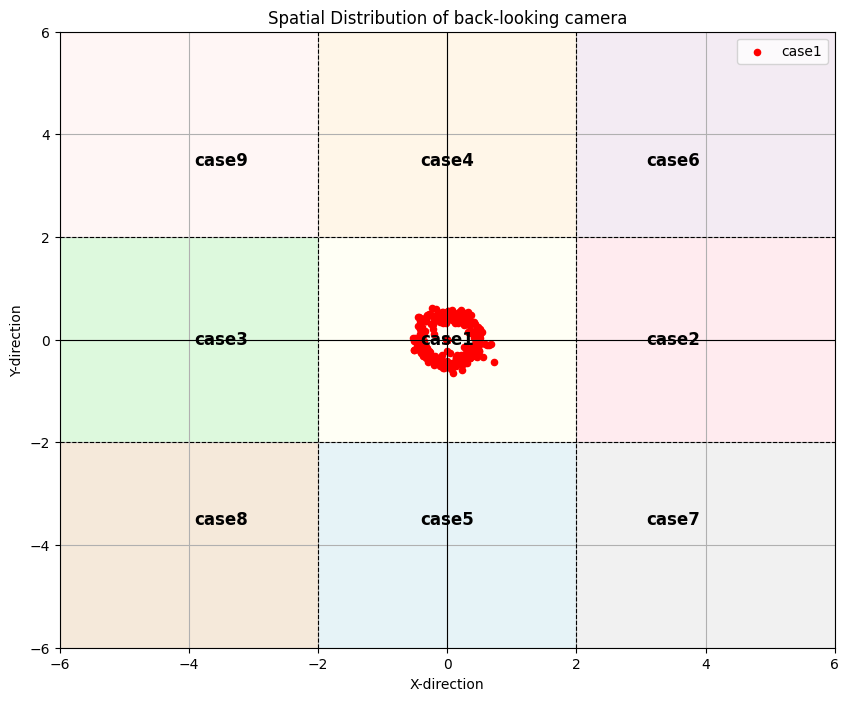

In [56]:
runs = range(14007, 14052)
save_all_runs(runs)

all_x = []
all_y = []
for n in runs:
    result = analyze_file(n)
    if result:
        *_, xdata, ydata = result
        all_x.extend(xdata)
        all_y.extend(ydata)

draw_cases_from_xy(all_x, all_y)
